# GRU Î™®Îç∏

ÌîºÏ≤òÎäî Î∂ÑÏÑùÌïú Ï†ÑÏ≤¥ Î≥ÄÏàòÎ°ú ÏÑ†ÌÉù

## 1.L1, L2 Ï†ÅÏö©

In [1]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

**  Î®∏Ïã†Îü¨ÎãùÏóêÏÑúÎäî Îã§Ï§ëÍ≥µÏÑ†ÏÑ± ÏÇ¨Ïö© ÏïàÌï®! (Ï†úÏô∏ÌïòÍ≥† ÎèåÎ¶¨Í∏∞)

In [2]:
import pandas as pd
final_exchange = pd.read_csv('/content/final.csv')

- ÏãúÎìú Í≥†Ï†ï

In [3]:
import random
import numpy as np
import tensorflow as tf
import os

def set_seed(seed=50):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

- GRU Î™®Îç∏

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

set_seed(50)

# Feature Î∞è Target ÏÑ§Ï†ï
features = ['Í≤ΩÏ†ú Ïã¨Î¶¨ ÏßÄÏàò', 'ÌïúÍµ≠ Í∏∞Ï§Ä Í∏àÎ¶¨', 'ÎØ∏Íµ≠ Í∏∞Ï§Ä Í∏àÎ¶¨', 'ÌïúÍµ≠ Ïô∏Ìôò Î≥¥Ïú†Ïï°',
            'ÌïúÍµ≠ Ïã§ÏóÖÎ•†', 'ÎØ∏Íµ≠ Ïã§ÏóÖÎ•†', 'ÌïúÍµ≠ Ï£ºÍ∞ÄÏßÄÏàò', 'ÎØ∏Íµ≠ Ï£ºÍ∞ÄÏßÄÏàò', 'WTI Ïú†Í∞Ä', 'ÎëêÎ∞îÏù¥ Ïú†Í∞Ä',
            'Brent Ïú†Í∞Ä', 'Ï≤úÏó∞Í∞ÄÏä§ Í∞ÄÍ≤©', 'Ïú†Ïó∞ÌÉÑ Í∞ÄÍ≤©', 'Ï≤†Í¥ëÏÑù Í∞ÄÍ≤©', 'Íµ¨Î¶¨ Í∞ÄÍ≤©',
            'ÏïåÎ£®ÎØ∏ÎäÑ Í∞ÄÍ≤©', 'ÎãàÏºà Í∞ÄÍ≤©', 'ÏïÑÏó∞ Í∞ÄÍ≤©', 'Í∏à Í∞ÄÍ≤©', 'ÎåÄÎëê Í∞ÄÍ≤©', 'Ïô∏Íµ≠Ïù∏ Ìà¨Ïûê Í∏àÏï°',
            'Ïò•ÏàòÏàò Í∞ÄÍ≤©', 'ÏÜåÎß• Í∞ÄÍ≤©', 'ÏõêÎãπ Í∞ÄÍ≤©', 'ÏõêÎ©¥ Í∞ÄÍ≤©',
            'ÌïúÍµ≠ Í≤ΩÏÉÅÏàòÏßÄ', 'ÌïúÍµ≠ Ïù∏ÌîåÎ†àÏù¥ÏÖòÏú®', 'Ïù∏ÌîåÎ†àÏù¥ÏÖò Í≤©Ï∞®',
            'Ïã§ÏßàGDP', 'Ïã§ÏßàGDPÏÑ±Ïû•Î•†', 'vix']
target = 'Ïõê/Îã¨Îü¨ÌôòÏú®'

# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
X = final_exchange[features].fillna(method='ffill').fillna(method='bfill')
y = final_exchange[target].loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

# Ï†ïÍ∑úÌôî
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# ÏãúÌÄÄÏä§ ÏÉùÏÑ±
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# GRU ÌïôÏäµ Î∞è ÌèâÍ∞Ä
def train_gru(X_train_sel, X_test_sel, l1_value=0.0, l2_value=0.0):
    X_train_seq, y_train_seq = create_sequences(X_train_sel, y_train_scaled)
    X_test_seq, y_test_seq = create_sequences(X_test_sel, y_test_scaled)

    model = Sequential()
    model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                  kernel_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value)))
    model.add(GRU(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16, validation_data=(X_test_seq, y_test_seq),
              callbacks=[early_stop], verbose=0)

    y_pred_scaled = model.predict(X_test_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test_seq)

    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    mae = mean_absolute_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)

    return rmse, mae, r2, y_test_actual, y_pred

# L1, L2 ÏÑ§Ï†ï
l1_values = [0.0, 0.001, 0.01]
l2_values = [0.0, 0.001, 0.01]

# Í≤∞Í≥º Ï†ÄÏû•
all_results = []
y_test_actual_best = None
y_pred_best = None

# ÏÑ†ÌÉùÎ≤ïÎ≥Ñ loop
for method_name, selector in [
    ("Ï†ÑÏßÑ ÏÑ†ÌÉùÎ≤ï", SequentialFeatureSelector(LinearRegression(), n_features_to_select='auto', direction='forward')),
    ("ÌõÑÏßÑ ÏÑ†ÌÉùÎ≤ï", SequentialFeatureSelector(LinearRegression(), n_features_to_select='auto', direction='backward')),
    ("Îã®Í≥ÑÏ†Å ÏÑ†ÌÉùÎ≤ï", SFS(LinearRegression(), k_features='best', forward=True, floating=True, scoring='r2', cv=0))
]:
    if method_name == "Îã®Í≥ÑÏ†Å ÏÑ†ÌÉùÎ≤ï":
        selector = selector.fit(X_train_scaled, y_train_scaled.ravel())
        selected_idx = list(selector.k_feature_idx_)
    else:
        selector = selector.fit(X_train_scaled, y_train_scaled.ravel())
        selected_idx = selector.get_support(indices=True)

    selected_features = np.array(features)[selected_idx]
    print(f"\n‚úÖ {method_name} ÏÑ†ÌÉùÎêú feature: {selected_features}")

    X_train_sel = X_train_scaled[:, selected_idx]
    X_test_sel = X_test_scaled[:, selected_idx]

    for l1 in l1_values:
        for l2 in l2_values:
            rmse, mae, r2, y_actual, y_pred = train_gru(X_train_sel, X_test_sel, l1, l2)

            # Ï†ÑÏßÑ ÏÑ†ÌÉùÎ≤ï + L1=0.0 + L2=0.0Ïùº Í≤ΩÏö∞ ÏãúÍ∞ÅÌôîÏö© Í∞í Ï†ÄÏû•
            if method_name == "Ï†ÑÏßÑ ÏÑ†ÌÉùÎ≤ï" and l1 == 0.0 and l2 == 0.0:
                y_test_actual_best = y_actual
                y_pred_best = y_pred

            all_results.append({
                'Method': method_name,
                'L1': l1,
                'L2': l2,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })
            print(f"‚Üí L1: {l1}, L2: {l2} ‚Üí RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

# Í≤∞Í≥º Ï†ïÎ¶¨
results_df = pd.DataFrame(all_results)
print("\n=== Ï†ÑÏ≤¥ Í≤∞Í≥º (RMSE Í∏∞Ï§Ä Ï†ïÎ†¨) ===")
print(results_df.sort_values(by='RMSE'))

<ipython-input-5-2fbba08a349b>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = final_exchange[features].fillna(method='ffill').fillna(method='bfill')



‚úÖ Ï†ÑÏßÑ ÏÑ†ÌÉùÎ≤ï ÏÑ†ÌÉùÎêú feature: ['Í≤ΩÏ†ú Ïã¨Î¶¨ ÏßÄÏàò' 'ÌïúÍµ≠ Í∏∞Ï§Ä Í∏àÎ¶¨' 'ÎëêÎ∞îÏù¥ Ïú†Í∞Ä' 'Brent Ïú†Í∞Ä' 'Ï≤úÏó∞Í∞ÄÏä§ Í∞ÄÍ≤©' 'Ï≤†Í¥ëÏÑù Í∞ÄÍ≤©' 'Íµ¨Î¶¨ Í∞ÄÍ≤©'
 'ÏïåÎ£®ÎØ∏ÎäÑ Í∞ÄÍ≤©' 'ÎãàÏºà Í∞ÄÍ≤©' 'Ïô∏Íµ≠Ïù∏ Ìà¨Ïûê Í∏àÏï°' 'ÏÜåÎß• Í∞ÄÍ≤©' 'ÏõêÎãπ Í∞ÄÍ≤©' 'ÌïúÍµ≠ Í≤ΩÏÉÅÏàòÏßÄ' 'ÌïúÍµ≠ Ïù∏ÌîåÎ†àÏù¥ÏÖòÏú®' 'vix']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 347ms/step
‚Üí L1: 0.0, L2: 0.0 ‚Üí RMSE: 145.8452, MAE: 132.8086, R^2: -1.5080


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 354ms/step
‚Üí L1: 0.0, L2: 0.001 ‚Üí RMSE: 140.5519, MAE: 129.0134, R^2: -1.3293


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 327ms/step

2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 359ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


‚Üí L1: 0.0, L2: 0.01 ‚Üí RMSE: 132.9348, MAE: 116.4993, R^2: -1.0837
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 346ms/step
‚Üí L1: 0.001, L2: 0.0 ‚Üí RMSE: 141.3606, MAE: 121.2118, R^2: -1.3562


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 356ms/step
‚Üí L1: 0.001, L2: 0.001 ‚Üí RMSE: 141.7545, MAE: 125.3867, R^2: -1.3693


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 337ms/step
‚Üí L1: 0.001, L2: 0.01 ‚Üí RMSE: 136.2836, MAE: 119.1527, R^2: -1.1900


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 355ms/step
‚Üí L1: 0.01, L2: 0.0 ‚Üí RMSE: 124.3600, MAE: 108.3785, R^2: -0.8235


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 338ms/step
‚Üí L1: 0.01, L2: 0.001 ‚Üí RMSE: 125.8130, MAE: 107.5145, R^2: -0.8664


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 496ms/step
‚Üí L1: 0.01, L2: 0.01 ‚Üí RMSE: 111.0281, MAE: 96.9337, R^2: -0.4535

‚úÖ ÌõÑÏßÑ ÏÑ†ÌÉùÎ≤ï ÏÑ†ÌÉùÎêú feature: ['Í≤ΩÏ†ú Ïã¨Î¶¨ ÏßÄÏàò' 'ÌïúÍµ≠ Ïô∏Ìôò Î≥¥Ïú†Ïï°' 'ÎØ∏Íµ≠ Ïã§ÏóÖÎ•†' 'ÎØ∏Íµ≠ Ï£ºÍ∞ÄÏßÄÏàò' 'ÎëêÎ∞îÏù¥ Ïú†Í∞Ä' 'Brent Ïú†Í∞Ä' 'Ï≤úÏó∞Í∞ÄÏä§ Í∞ÄÍ≤©'
 'Ïú†Ïó∞ÌÉÑ Í∞ÄÍ≤©' 'Ï≤†Í¥ëÏÑù Í∞ÄÍ≤©' 'ÏïåÎ£®ÎØ∏ÎäÑ Í∞ÄÍ≤©' 'ÎãàÏºà Í∞ÄÍ≤©' 'Ïò•ÏàòÏàò Í∞ÄÍ≤©' 'ÏÜåÎß• Í∞ÄÍ≤©' 'ÌïúÍµ≠ Í≤ΩÏÉÅÏàòÏßÄ'
 'ÌïúÍµ≠ Ïù∏ÌîåÎ†àÏù¥ÏÖòÏú®' 'vix']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 492ms/step
‚Üí L1: 0.0, L2: 0.0 ‚Üí RMSE: 85.7869, MAE: 78.8372, R^2: 0.1323


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 364ms/step
‚Üí L1: 0.0, L2: 0.001 ‚Üí RMSE: 102.6221, MAE: 84.8080, R^2: -0.2417


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 346ms/step
‚Üí L1: 0.0, L2: 0.01 ‚Üí RMSE: 114.7395, MAE: 89.8602, R^2: -0.5523


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 342ms/step
‚Üí L1: 0.001, L2: 0.0 ‚Üí RMSE: 70.5116, MAE: 53.8438, R^2: 0.4138


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 348ms/step
‚Üí L1: 0.001, L2: 0.001 ‚Üí RMSE: 140.3027, MAE: 116.6203, R^2: -1.3210


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 354ms/step
‚Üí L1: 0.001, L2: 0.01 ‚Üí RMSE: 147.9904, MAE: 113.0248, R^2: -1.5824


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 344ms/step
‚Üí L1: 0.01, L2: 0.0 ‚Üí RMSE: 96.7822, MAE: 78.8864, R^2: -0.1044


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 346ms/step
‚Üí L1: 0.01, L2: 0.001 ‚Üí RMSE: 170.9831, MAE: 147.7707, R^2: -2.4471


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 351ms/step
‚Üí L1: 0.01, L2: 0.01 ‚Üí RMSE: 93.7695, MAE: 78.9077, R^2: -0.0368

‚úÖ Îã®Í≥ÑÏ†Å ÏÑ†ÌÉùÎ≤ï ÏÑ†ÌÉùÎêú feature: ['Í≤ΩÏ†ú Ïã¨Î¶¨ ÏßÄÏàò' 'ÌïúÍµ≠ Í∏∞Ï§Ä Í∏àÎ¶¨' 'ÎØ∏Íµ≠ Í∏∞Ï§Ä Í∏àÎ¶¨' 'ÌïúÍµ≠ Ïô∏Ìôò Î≥¥Ïú†Ïï°' 'ÌïúÍµ≠ Ïã§ÏóÖÎ•†' 'ÎØ∏Íµ≠ Ïã§ÏóÖÎ•†' 'ÌïúÍµ≠ Ï£ºÍ∞ÄÏßÄÏàò'
 'ÎØ∏Íµ≠ Ï£ºÍ∞ÄÏßÄÏàò' 'WTI Ïú†Í∞Ä' 'ÎëêÎ∞îÏù¥ Ïú†Í∞Ä' 'Brent Ïú†Í∞Ä' 'Ï≤úÏó∞Í∞ÄÏä§ Í∞ÄÍ≤©' 'Ïú†Ïó∞ÌÉÑ Í∞ÄÍ≤©' 'Ï≤†Í¥ëÏÑù Í∞ÄÍ≤©'
 'Íµ¨Î¶¨ Í∞ÄÍ≤©' 'ÏïåÎ£®ÎØ∏ÎäÑ Í∞ÄÍ≤©' 'ÎãàÏºà Í∞ÄÍ≤©' 'ÏïÑÏó∞ Í∞ÄÍ≤©' 'Í∏à Í∞ÄÍ≤©' 'ÎåÄÎëê Í∞ÄÍ≤©' 'Ïô∏Íµ≠Ïù∏ Ìà¨Ïûê Í∏àÏï°' 'Ïò•ÏàòÏàò Í∞ÄÍ≤©'
 'ÏÜåÎß• Í∞ÄÍ≤©' 'ÏõêÎãπ Í∞ÄÍ≤©' 'ÏõêÎ©¥ Í∞ÄÍ≤©' 'ÌïúÍµ≠ Í≤ΩÏÉÅÏàòÏßÄ' 'ÌïúÍµ≠ Ïù∏ÌîåÎ†àÏù¥ÏÖòÏú®' 'Ïù∏ÌîåÎ†àÏù¥ÏÖò Í≤©Ï∞®' 'Ïã§ÏßàGDP'
 'Ïã§ÏßàGDPÏÑ±Ïû•Î•†' 'vix']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 370ms/step
‚Üí L1: 0.0, L2: 0.0 ‚Üí RMSE: 75.8802, MAE: 66.9470, R^2: 0.3211


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 357ms/step
‚Üí L1: 0.0, L2: 0.001 ‚Üí RMSE: 123.3657, MAE: 102.7137, R^2: -0.7945


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 337ms/step
‚Üí L1: 0.0, L2: 0.01 ‚Üí RMSE: 101.7397, MAE: 82.5137, R^2: -0.2205


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 485ms/step
‚Üí L1: 0.001, L2: 0.0 ‚Üí RMSE: 100.1255, MAE: 81.9872, R^2: -0.1821


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 349ms/step
‚Üí L1: 0.001, L2: 0.001 ‚Üí RMSE: 86.9224, MAE: 69.5813, R^2: 0.1091


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 505ms/step
‚Üí L1: 0.001, L2: 0.01 ‚Üí RMSE: 85.4432, MAE: 68.8740, R^2: 0.1392


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 362ms/step
‚Üí L1: 0.01, L2: 0.0 ‚Üí RMSE: 56.8256, MAE: 44.4941, R^2: 0.6192


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 357ms/step
‚Üí L1: 0.01, L2: 0.001 ‚Üí RMSE: 66.9294, MAE: 53.8639, R^2: 0.4718


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 360ms/step
‚Üí L1: 0.01, L2: 0.01 ‚Üí RMSE: 79.2582, MAE: 63.2198, R^2: 0.2593

=== Ï†ÑÏ≤¥ Í≤∞Í≥º (RMSE Í∏∞Ï§Ä Ï†ïÎ†¨) ===
     Method     L1     L2        RMSE         MAE        R2
24  Îã®Í≥ÑÏ†Å ÏÑ†ÌÉùÎ≤ï  0.010  0.000   56.825642   44.494144  0.619250
25  Îã®Í≥ÑÏ†Å ÏÑ†ÌÉùÎ≤ï  0.010  0.001   66.929402   53.863873  0.471816
12   ÌõÑÏßÑ ÏÑ†ÌÉùÎ≤ï  0.001  0.000   70.511563   53.843845  0.413764
18  Îã®Í≥ÑÏ†Å ÏÑ†ÌÉùÎ≤ï  0.000  0.000   75.880164   66.947002  0.321097
26  Îã®Í≥ÑÏ†Å ÏÑ†ÌÉùÎ≤ï  0.010  0.010   79.258183   63.219823  0.259304
23  Îã®Í≥ÑÏ†Å ÏÑ†ÌÉùÎ≤ï  0.001  0.010   85.443249   68.874011  0.139191
9    ÌõÑÏßÑ ÏÑ†ÌÉùÎ≤ï  0.000  0.000   85.786871   78.837160  0.132253
22  Îã®Í≥ÑÏ†Å ÏÑ†ÌÉùÎ≤ï  0.001  0.001   86.922425   69.581272  0.109128
17   ÌõÑÏßÑ ÏÑ†ÌÉùÎ≤ï  0.010  0.010   93.769468   78.907669 -0.036751
15   ÌõÑÏßÑ ÏÑ†ÌÉùÎ≤ï  0.010  0.000   96.782167   78.886426 -0.104440
21  Îã®Í≥ÑÏ†Å ÏÑ†ÌÉùÎ≤ï  0.001  0.000

- Í∑∏ÎûòÌîÑ

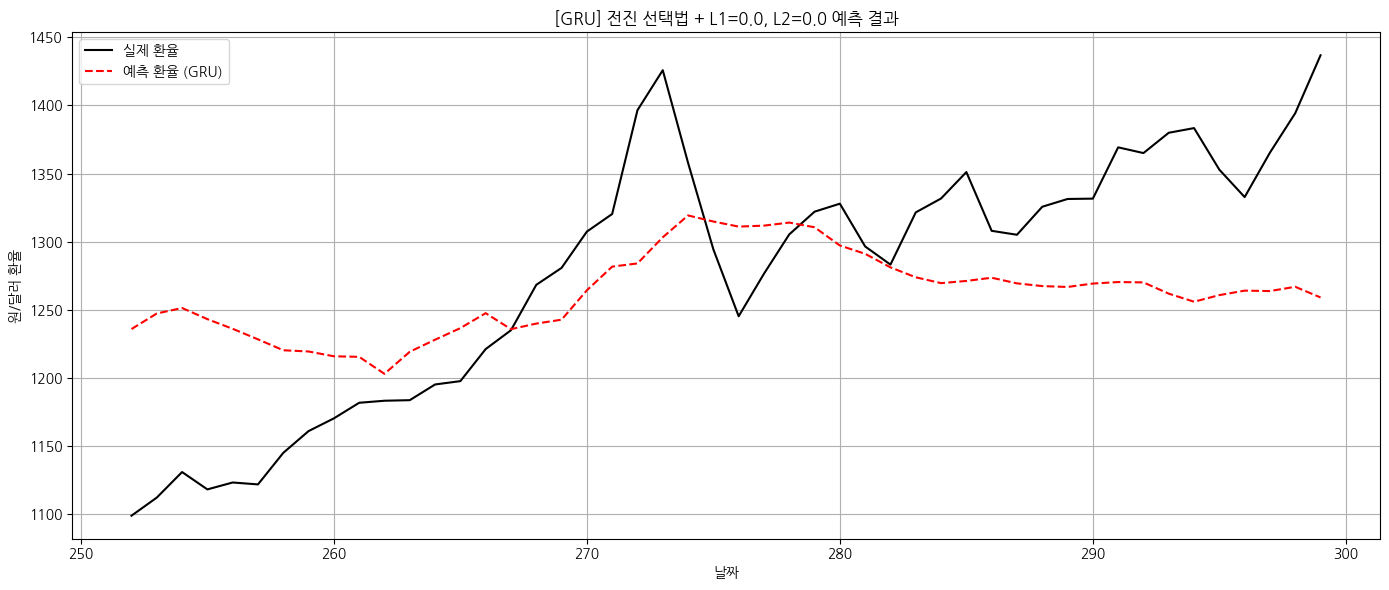

In [ ]:
# Í∑∏ÎûòÌîÑ ÏãúÍ∞ÅÌôî
import matplotlib.pyplot as plt

if y_test_actual_best is not None and y_pred_best is not None:
    test_dates = y_test.index[-len(y_test_actual_best):]

    plt.figure(figsize=(14, 6))
    plt.plot(test_dates, y_test_actual_best, label='Ïã§Ï†ú ÌôòÏú®', color='black')
    plt.plot(test_dates, y_pred_best, label='ÏòàÏ∏° ÌôòÏú® (GRU)', color='red', linestyle='--')
    plt.title('[GRU] Ï†ÑÏßÑ ÏÑ†ÌÉùÎ≤ï + L1=0.0, L2=0.0 ÏòàÏ∏° Í≤∞Í≥º')
    plt.xlabel('ÎÇ†Ïßú')
    plt.ylabel('Ïõê/Îã¨Îü¨ ÌôòÏú®')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 2.GRU(Permutation Importance TOP10) Î™®Îç∏

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 587ms/step
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 31ms/step
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 37ms/step
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 34ms/step
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 34ms/step
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 30ms/step
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 32ms/step
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 39ms/step
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 31ms/step
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 36ms/step
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 45ms/step
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 34ms/step
2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

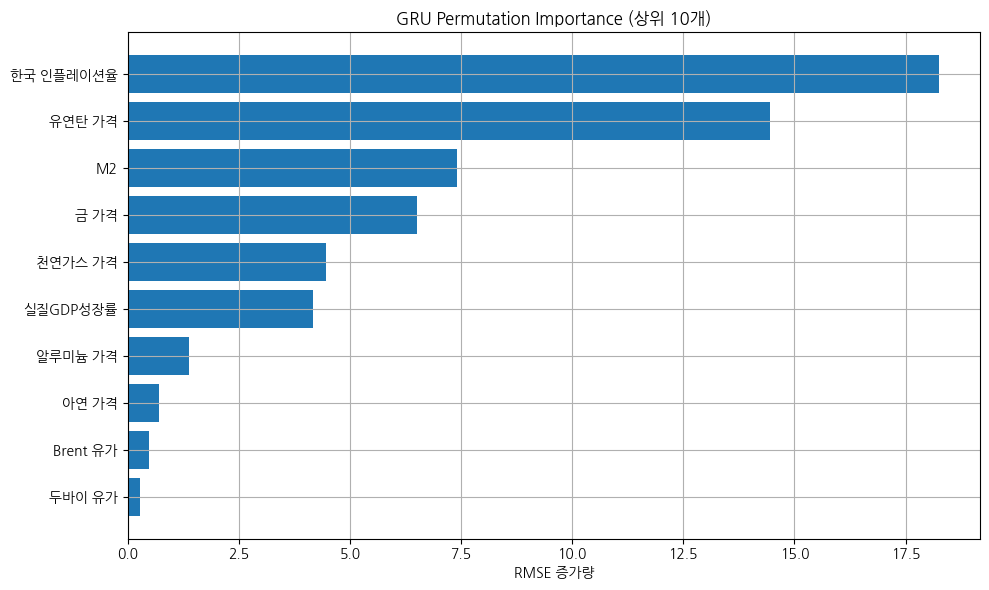

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ===== 1. ÏãúÎìú Í≥†Ï†ï =====
import random, os, tensorflow as tf
def set_seed(seed=50):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(50)

# ===== 2. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ =====
features = ['Í≤ΩÏ†ú Ïã¨Î¶¨ ÏßÄÏàò', 'ÌïúÍµ≠ Í∏∞Ï§Ä Í∏àÎ¶¨', 'ÎØ∏Íµ≠ Í∏∞Ï§Ä Í∏àÎ¶¨', 'ÌïúÍµ≠ Ïô∏Ìôò Î≥¥Ïú†Ïï°',
            'ÌïúÍµ≠ Ïã§ÏóÖÎ•†', 'ÎØ∏Íµ≠ Ïã§ÏóÖÎ•†', 'ÌïúÍµ≠ Ï£ºÍ∞ÄÏßÄÏàò', 'ÎØ∏Íµ≠ Ï£ºÍ∞ÄÏßÄÏàò', 'WTI Ïú†Í∞Ä', 'ÎëêÎ∞îÏù¥ Ïú†Í∞Ä',
            'Brent Ïú†Í∞Ä', 'Ï≤úÏó∞Í∞ÄÏä§ Í∞ÄÍ≤©', 'Ïú†Ïó∞ÌÉÑ Í∞ÄÍ≤©', 'Ï≤†Í¥ëÏÑù Í∞ÄÍ≤©', 'Íµ¨Î¶¨ Í∞ÄÍ≤©',
            'ÏïåÎ£®ÎØ∏ÎäÑ Í∞ÄÍ≤©', 'ÎãàÏºà Í∞ÄÍ≤©', 'ÏïÑÏó∞ Í∞ÄÍ≤©', 'Í∏à Í∞ÄÍ≤©', 'ÎåÄÎëê Í∞ÄÍ≤©', 'Ïô∏Íµ≠Ïù∏ Ìà¨Ïûê Í∏àÏï°',
            'Ïò•ÏàòÏàò Í∞ÄÍ≤©', 'ÏÜåÎß• Í∞ÄÍ≤©', 'ÏõêÎãπ Í∞ÄÍ≤©', 'ÏõêÎ©¥ Í∞ÄÍ≤©',
            'ÌïúÍµ≠ Í≤ΩÏÉÅÏàòÏßÄ', 'ÌïúÍµ≠ Ïù∏ÌîåÎ†àÏù¥ÏÖòÏú®', 'Ïù∏ÌîåÎ†àÏù¥ÏÖò Í≤©Ï∞®',
            'Ïã§ÏßàGDP', 'Ïã§ÏßàGDPÏÑ±Ïû•Î•†', 'vix']
target = 'Ïõê/Îã¨Îü¨ÌôòÏú®'

X = final_exchange[features].ffill().bfill()
y = final_exchange[target].loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

# ===== 3. GRU Î™®Îç∏ ÌïôÏäµ =====
model = Sequential()
model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(GRU(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16,
          validation_data=(X_test_seq, y_test_seq), callbacks=[early_stop], verbose=0)

# ===== 4. Permutation Importance Í≥ÑÏÇ∞ Ìï®Ïàò =====
def permutation_importance_gru(model, X_seq, y_seq, feature_names, scaler_y):
    baseline_preds = model.predict(X_seq)
    baseline_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_seq),
                                               scaler_y.inverse_transform(baseline_preds)))

    importances = []
    for i in range(X_seq.shape[2]):
        X_permuted = X_seq.copy()
        np.random.shuffle(X_permuted[:, :, i])  # iÎ≤àÏß∏ featureÎßå ÏÑûÍ∏∞

        preds = model.predict(X_permuted)
        rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_seq),
                                          scaler_y.inverse_transform(preds)))
        drop = rmse - baseline_rmse
        importances.append((feature_names[i], drop))

    importances.sort(key=lambda x: x[1], reverse=True)
    return importances

# ===== 5. Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞ Î∞è ÏãúÍ∞ÅÌôî =====
importances = permutation_importance_gru(model, X_test_seq, y_test_seq, features, scaler_y)

# Ï∂úÎ†•
print("\nGRU Permutation Importance (Top 10):")
for name, drop in importances[:10]:
    print(f"{name}: RMSE Ï¶ùÍ∞ÄÎüâ = {drop:.4f}")

# ÏãúÍ∞ÅÌôî
names = [x[0] for x in importances[:10]]
scores = [x[1] for x in importances[:10]]

plt.figure(figsize=(10, 6))
plt.barh(names[::-1], scores[::-1])
plt.xlabel("RMSE Ï¶ùÍ∞ÄÎüâ")
plt.title("GRU Permutation Importance (ÏÉÅÏúÑ 10Í∞ú)")
plt.grid(True)
plt.tight_layout()
plt.show()

### 2-1.ÏÑ†ÌÉùÎêú TOP 10ÏúºÎ°ú GRU ÌïôÏäµ

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 368ms/step

üìà Top 10 Feature GRU ÏòàÏ∏° ÏÑ±Îä•
‚úÖ RMSE: 57.6703
‚úÖ MAE : 43.9310
‚úÖ R¬≤  : 0.6078


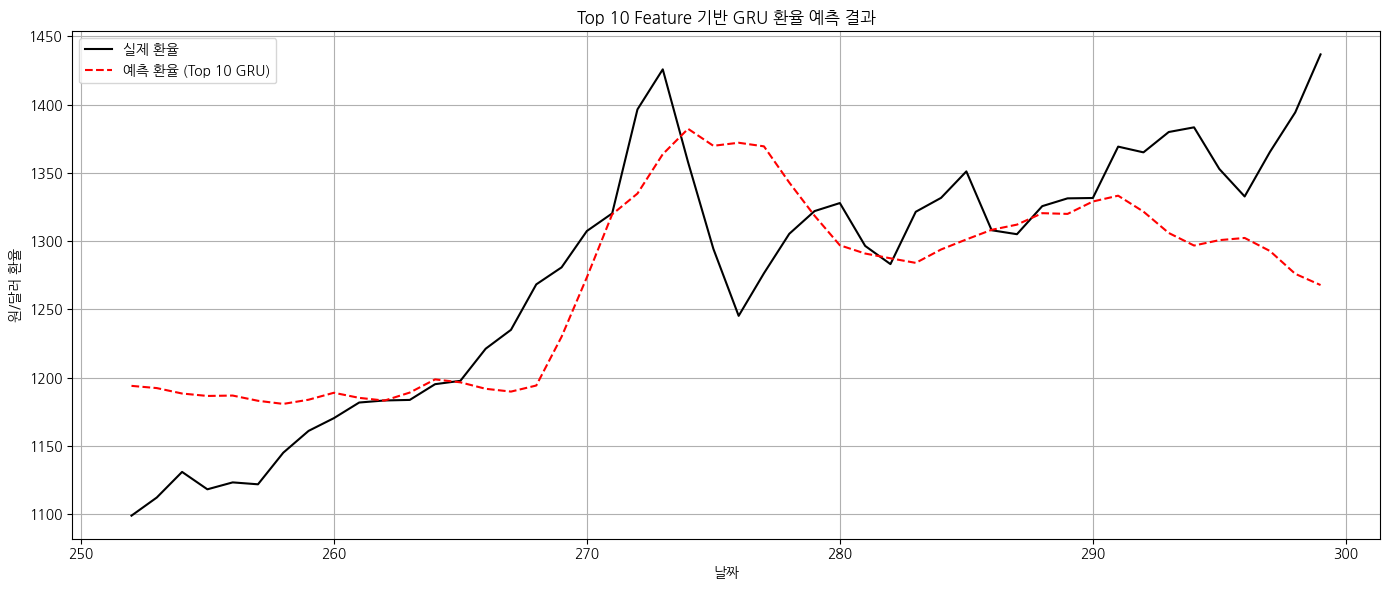

In [6]:
import numpy as np
import pandas as pd
import random, os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

set_seed(50)

# ‚úÖ ÏÑ†ÌÉùÎêú Top 10 ÌîºÏ≤ò
top10_features = [
    'ÌïúÍµ≠ Ïù∏ÌîåÎ†àÏù¥ÏÖòÏú®',
    'Ïú†Ïó∞ÌÉÑ Í∞ÄÍ≤©',
    'M2',
    'Í∏à Í∞ÄÍ≤©',
    'Ï≤úÏó∞Í∞ÄÏä§ Í∞ÄÍ≤©',
    'Ïã§ÏßàGDPÏÑ±Ïû•Î•†',
    'ÏïåÎ£®ÎØ∏ÎäÑ Í∞ÄÍ≤©',
    'ÏïÑÏó∞ Í∞ÄÍ≤©',
    'Brent Ïú†Í∞Ä',
    'ÎëêÎ∞îÏù¥ Ïú†Í∞Ä'
]

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
X_top10 = final_exchange[top10_features].ffill().bfill()
y = final_exchange['Ïõê/Îã¨Îü¨ÌôòÏú®'].loc[X_top10.index]

X_train, X_test, y_train, y_test = train_test_split(X_top10, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# ‚úÖ ÏãúÌÄÄÏä§ ÏÉùÏÑ± Ìï®Ïàò
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

# ‚úÖ GRU Î™®Îç∏ Ï†ïÏùò Î∞è ÌïôÏäµ
model = Sequential()
model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(GRU(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16,
          validation_data=(X_test_seq, y_test_seq), callbacks=[early_stop], verbose=0)

# ‚úÖ ÏòàÏ∏° Î∞è ÏÑ±Îä• ÌèâÍ∞Ä
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"\nüìà Top 10 Feature GRU ÏòàÏ∏° ÏÑ±Îä•")
print(f"‚úÖ RMSE: {rmse:.4f}")
print(f"‚úÖ MAE : {mae:.4f}")
print(f"‚úÖ R¬≤  : {r2:.4f}")

# ‚úÖ ÏãúÍ∞ÅÌôî
import matplotlib.pyplot as plt

test_dates = y_test.index[-len(y_test_actual):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label='Ïã§Ï†ú ÌôòÏú®', color='black')
plt.plot(test_dates, y_pred, label='ÏòàÏ∏° ÌôòÏú® (Top 10 GRU)', color='red', linestyle='--')
plt.title('Top 10 Feature Í∏∞Î∞ò GRU ÌôòÏú® ÏòàÏ∏° Í≤∞Í≥º')
plt.xlabel('ÎÇ†Ïßú')
plt.ylabel('Ïõê/Îã¨Îü¨ ÌôòÏú®')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.GRU(LASSO Top 10 Feature) Î™®Îç∏

‚úÖ LASSO Í∏∞Î∞ò Top 10 ÌîºÏ≤ò:
['ÏïåÎ£®ÎØ∏ÎäÑ Í∞ÄÍ≤©', 'Ïù∏ÌîåÎ†àÏù¥ÏÖò Í≤©Ï∞®', 'vix', 'ÎØ∏Íµ≠ Í∏∞Ï§Ä Í∏àÎ¶¨', 'ÌïúÍµ≠ Ïô∏Ìôò Î≥¥Ïú†Ïï°', 'Í≤ΩÏ†ú Ïã¨Î¶¨ ÏßÄÏàò', 'ÌïúÍµ≠ Í∏∞Ï§Ä Í∏àÎ¶¨', 'ÎØ∏Íµ≠ Ï£ºÍ∞ÄÏßÄÏàò', 'WTI Ïú†Í∞Ä', 'ÎëêÎ∞îÏù¥ Ïú†Í∞Ä']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 346ms/step

üìà GRU (LASSO Top 10 Feature) ÏÑ±Îä•
‚úÖ RMSE: 124.5126
‚úÖ MAE : 105.9286
‚úÖ R¬≤  : -0.8280


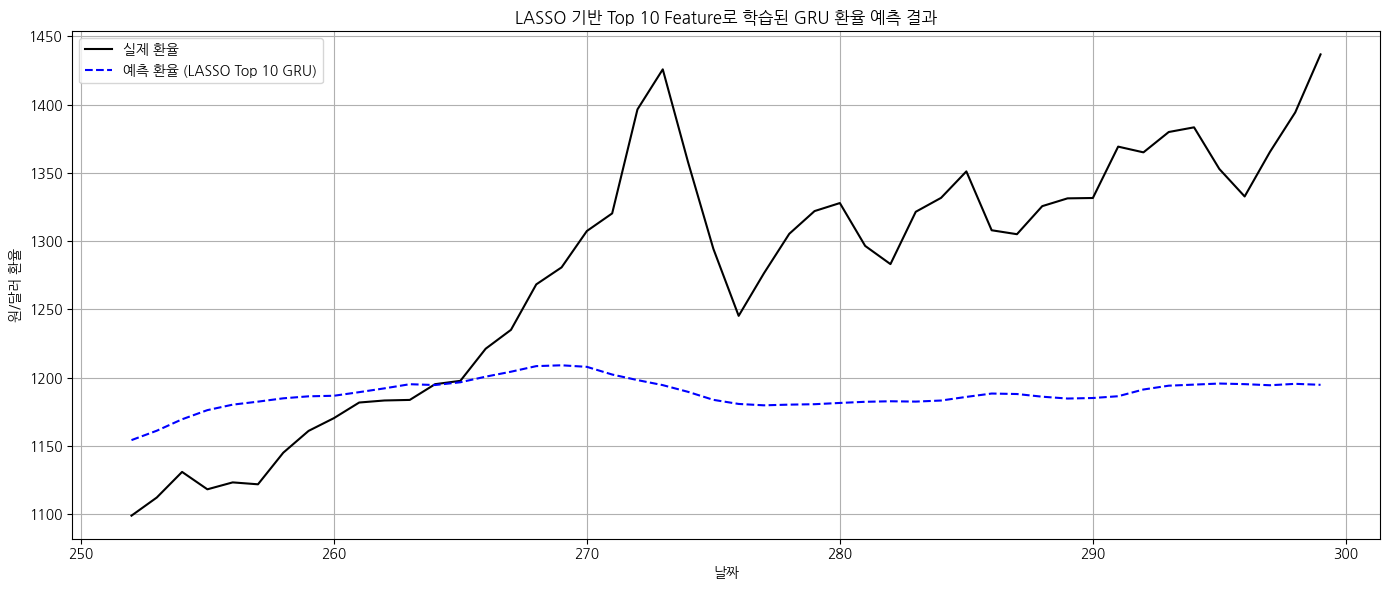

In [8]:
# ‚úÖ ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

set_seed(50)

# ‚úÖ Ï†ÑÏ≤¥ ÌîºÏ≤ò Ï†ïÏùò
features = ['Í≤ΩÏ†ú Ïã¨Î¶¨ ÏßÄÏàò', 'ÌïúÍµ≠ Í∏∞Ï§Ä Í∏àÎ¶¨', 'ÎØ∏Íµ≠ Í∏∞Ï§Ä Í∏àÎ¶¨', 'ÌïúÍµ≠ Ïô∏Ìôò Î≥¥Ïú†Ïï°',
            'ÌïúÍµ≠ Ïã§ÏóÖÎ•†', 'ÎØ∏Íµ≠ Ïã§ÏóÖÎ•†', 'ÌïúÍµ≠ Ï£ºÍ∞ÄÏßÄÏàò', 'ÎØ∏Íµ≠ Ï£ºÍ∞ÄÏßÄÏàò', 'WTI Ïú†Í∞Ä', 'ÎëêÎ∞îÏù¥ Ïú†Í∞Ä',
            'Brent Ïú†Í∞Ä', 'Ï≤úÏó∞Í∞ÄÏä§ Í∞ÄÍ≤©', 'Ïú†Ïó∞ÌÉÑ Í∞ÄÍ≤©', 'Ï≤†Í¥ëÏÑù Í∞ÄÍ≤©', 'Íµ¨Î¶¨ Í∞ÄÍ≤©',
            'ÏïåÎ£®ÎØ∏ÎäÑ Í∞ÄÍ≤©', 'ÎãàÏºà Í∞ÄÍ≤©', 'ÏïÑÏó∞ Í∞ÄÍ≤©', 'Í∏à Í∞ÄÍ≤©', 'ÎåÄÎëê Í∞ÄÍ≤©', 'Ïô∏Íµ≠Ïù∏ Ìà¨Ïûê Í∏àÏï°',
            'Ïò•ÏàòÏàò Í∞ÄÍ≤©', 'ÏÜåÎß• Í∞ÄÍ≤©', 'ÏõêÎãπ Í∞ÄÍ≤©', 'ÏõêÎ©¥ Í∞ÄÍ≤©',
            'ÌïúÍµ≠ Í≤ΩÏÉÅÏàòÏßÄ', 'ÌïúÍµ≠ Ïù∏ÌîåÎ†àÏù¥ÏÖòÏú®', 'Ïù∏ÌîåÎ†àÏù¥ÏÖò Í≤©Ï∞®',
            'Ïã§ÏßàGDP', 'Ïã§ÏßàGDPÏÑ±Ïû•Î•†', 'vix']
target = 'Ïõê/Îã¨Îü¨ÌôòÏú®'

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
X = final_exchange[features].ffill().bfill()
y = final_exchange[target].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# ‚úÖ LASSO Í∏∞Î∞ò Top 10 ÌîºÏ≤ò ÏÑ†ÌÉù
lasso = Lasso(alpha=0.01, random_state=50, max_iter=10000)
lasso.fit(X_train_scaled, y_train_scaled.ravel())
feature_importance = pd.Series(np.abs(lasso.coef_), index=features)
top10_lasso_features = feature_importance.sort_values(ascending=False).head(10).index.tolist()

print("‚úÖ LASSO Í∏∞Î∞ò Top 10 ÌîºÏ≤ò:")
print(top10_lasso_features)

# ‚úÖ Top 10 ÌîºÏ≤òÎßå Îã§Ïãú Ïä§ÏºÄÏùºÎßÅ Î∞è ÏãúÌÄÄÏä§ ÏÉùÏÑ±
X_top10 = final_exchange[top10_lasso_features].ffill().bfill()
X_train, X_test, y_train, y_test = train_test_split(X_top10, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

# ‚úÖ GRU Î™®Îç∏ ÌïôÏäµ
model = Sequential()
model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(GRU(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16,
          validation_data=(X_test_seq, y_test_seq), callbacks=[early_stop], verbose=0)

# ‚úÖ ÏÑ±Îä• ÌèâÍ∞Ä
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"\nüìà GRU (LASSO Top 10 Feature) ÏÑ±Îä•")
print(f"‚úÖ RMSE: {rmse:.4f}")
print(f"‚úÖ MAE : {mae:.4f}")
print(f"‚úÖ R¬≤  : {r2:.4f}")

# ‚úÖ ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî
test_dates = y_test.index[-len(y_test_actual):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label='Ïã§Ï†ú ÌôòÏú®', color='black')
plt.plot(test_dates, y_pred, label='ÏòàÏ∏° ÌôòÏú® (LASSO Top 10 GRU)', color='blue', linestyle='--')
plt.title('LASSO Í∏∞Î∞ò Top 10 FeatureÎ°ú ÌïôÏäµÎêú GRU ÌôòÏú® ÏòàÏ∏° Í≤∞Í≥º')
plt.xlabel('ÎÇ†Ïßú')
plt.ylabel('Ïõê/Îã¨Îü¨ ÌôòÏú®')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4.GRU(Random ForestÍ∏∞Î∞ò feature_importance Top 10) Î™®Îç∏

‚úÖ Random Forest Í∏∞Î∞ò Top 10 ÌîºÏ≤ò:
['ÎØ∏Íµ≠ Ï£ºÍ∞ÄÏßÄÏàò', 'Ï≤úÏó∞Í∞ÄÏä§ Í∞ÄÍ≤©', 'ÏïåÎ£®ÎØ∏ÎäÑ Í∞ÄÍ≤©', 'ÎãàÏºà Í∞ÄÍ≤©', 'Í≤ΩÏ†ú Ïã¨Î¶¨ ÏßÄÏàò', 'ÏïÑÏó∞ Í∞ÄÍ≤©', 'vix', 'ÎØ∏Íµ≠ Í∏∞Ï§Ä Í∏àÎ¶¨', 'Í∏à Í∞ÄÍ≤©', 'ÏÜåÎß• Í∞ÄÍ≤©']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 343ms/step

üìà GRU (Random Forest Top 10 Feature) ÏÑ±Îä•
‚úÖ RMSE: 87.1911
‚úÖ MAE : 79.8747
‚úÖ R¬≤  : 0.1036


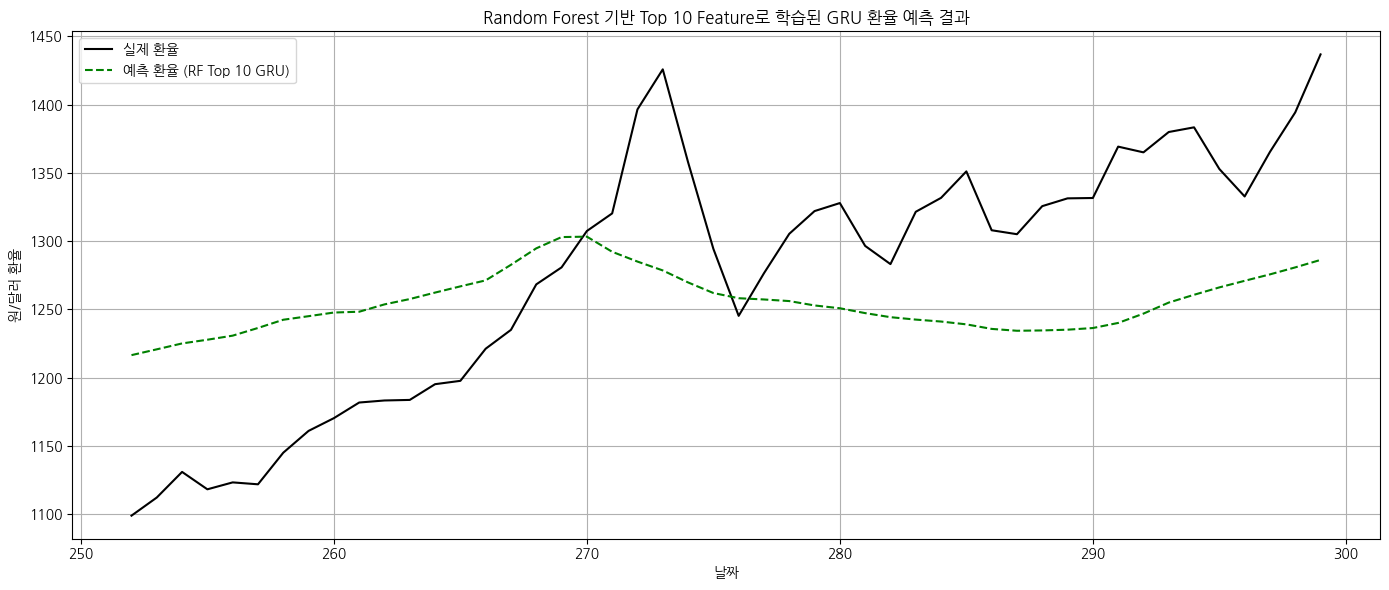

In [9]:
# ‚úÖ ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨
from sklearn.ensemble import RandomForestRegressor

# ‚úÖ 1. Random ForestÎ°ú ÌîºÏ≤ò Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞(Ï†ÑÏ≤¥ÌîºÏ≤òÏóêÏÑú Îã§Ïãú Ï†ïÏùò)
X_full = final_exchange[features].ffill().bfill()
y_full = final_exchange['Ïõê/Îã¨Îü¨ÌôòÏú®'].loc[X_full.index]

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, train_size=0.8, shuffle=False)

scaler_X_full = MinMaxScaler()
X_train_scaled_full = scaler_X_full.fit_transform(X_train_full)
X_test_scaled_full = scaler_X_full.transform(X_test_full)

scaler_y_dummy = MinMaxScaler()
y_train_scaled_full = scaler_y_dummy.fit_transform(y_train_full.values.reshape(-1, 1))

# ‚úÖ RandomForestRegressor ÌïôÏäµ (20Í∞ú ÌîºÏ≤ò Ï†ÑÏ≤¥ Í∏∞Ï§Ä)
rf = RandomForestRegressor(n_estimators=100, random_state=50)
rf.fit(X_train_scaled_full, y_train_scaled_full.ravel())

# ‚úÖ Ï†ïÌôïÌïú index Îß§Ïπ≠
rf_importance = pd.Series(rf.feature_importances_, index=X_full.columns)
top10_rf_features = rf_importance.sort_values(ascending=False).head(10).index.tolist()

print("‚úÖ Random Forest Í∏∞Î∞ò Top 10 ÌîºÏ≤ò:")
print(top10_rf_features)


# ‚úÖ 2. ÏÑ†ÌÉùÎêú Top 10 ÌîºÏ≤òÎ°ú Îç∞Ïù¥ÌÑ∞ Ïû¨Íµ¨ÏÑ±
X_top10 = final_exchange[top10_rf_features].ffill().bfill()
X_train, X_test, y_train, y_test = train_test_split(X_top10, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

# ‚úÖ 3. GRU Î™®Îç∏ Íµ¨ÏÑ± Î∞è ÌïôÏäµ
model = Sequential()
model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(GRU(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16,
          validation_data=(X_test_seq, y_test_seq), callbacks=[early_stop], verbose=0)

# ‚úÖ 4. ÏÑ±Îä• ÌèâÍ∞Ä
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"\nüìà GRU (Random Forest Top 10 Feature) ÏÑ±Îä•")
print(f"‚úÖ RMSE: {rmse:.4f}")
print(f"‚úÖ MAE : {mae:.4f}")
print(f"‚úÖ R¬≤  : {r2:.4f}")

# ‚úÖ 5. ÏòàÏ∏° ÏãúÍ∞ÅÌôî
test_dates = y_test.index[-len(y_test_actual):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label='Ïã§Ï†ú ÌôòÏú®', color='black')
plt.plot(test_dates, y_pred, label='ÏòàÏ∏° ÌôòÏú® (RF Top 10 GRU)', color='green', linestyle='--')
plt.title('Random Forest Í∏∞Î∞ò Top 10 FeatureÎ°ú ÌïôÏäµÎêú GRU ÌôòÏú® ÏòàÏ∏° Í≤∞Í≥º')
plt.xlabel('ÎÇ†Ïßú')
plt.ylabel('Ïõê/Îã¨Îü¨ ÌôòÏú®')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()